<a href="https://colab.research.google.com/github/MuhammadIrzam447/visionCodes/blob/master/Joint_Representation_images_ferramenta_ResNet_101_100_ImageMissing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report
import patoolib

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Mount Drive

In [ ]:
# drive.mount('/content/drive')

In [ ]:
# !gdown https://drive.google.com/uc?id=1p1qz1lDDwqrW-lTa11liOBMuWwIT8IP4

Downloading...
From: https://drive.google.com/uc?id=1p1qz1lDDwqrW-lTa11liOBMuWwIT8IP4
To: /content/mulitmodal_img_enc_txt.zip
100% 4.00G/4.00G [00:27<00:00, 145MB/s]


In [ ]:
# path = "/content/text_encodings-images-train.rar"

In [ ]:
# patoolib.extract_archive(path, outdir="/content/Data/")

In [ ]:
# import zipfile

# with zipfile.ZipFile("/content/mulitmodal_img_enc_txt.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/Data/")

# Extract Images

In [ ]:
# path = "/content/images-train.tar.gz"
# images-train.tar.gz
# images-val.tar.gz

In [ ]:
# os.chdir(path)

In [ ]:
# path = "/content/images-train.tar.gz"
# import tarfile

# with tarfile.open(path, 'r:gz') as tar_ref:
#     tar_ref.extractall('trainImages')

# Loading Training Dataset and Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class FragmentaDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    # def __getitem__(self, index):
    #     image, label = self.dataset[index]
    #     return image, label

    def __getitem__(self, index):
        while True:
            try:
                image, label = self.dataset[index]
                return image, label
            except (UnidentifiedImageError, FileNotFoundError) as e:
                print(f"Error loading image at index {index}: {e}")
                index += 1

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = "/content/Data/mulitmodal_img_enc_txt/images-train"
dataset = FragmentaDataset(data_dir)

In [ ]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 132282
Number of classes: 52


In [ ]:
batch_size = 32
num_workers = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# EDA

In [ ]:
class_length = dataset.class_lengths
class_labels = list(class_length.keys())

In [ ]:
from torchvision.transforms import ToPILImage

def plot_sample_images(dataset):


    # Create a grid layout based on the number of classes
    num_classes = len(class_length)
    grid_cols = 4  # Number of columns in the grid
    grid_rows = (num_classes + grid_cols - 1) // grid_cols  # Number of rows in the grid
    plt.figure(figsize=(10, 5 * grid_rows))

    # Create a transform to convert the tensor to PIL Image
    to_pil = ToPILImage()

    # Iterate over each class
    for i, class_label in enumerate(class_labels):
        # Get a random image index from the class
        image_index = np.random.choice(class_length[class_label])

        # Get the image and label from the dataset
        image, label = dataset[image_index]

        # Convert the image tensor to PIL Image
        image = to_pil(image)

        # Plot the image
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(image, interpolation='none')  # Use 'RGB' interpolation
        plt.title(class_label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
plot_sample_images(dataset)

In [ ]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 52
Total sum: 132282
dict_values([390, 11308, 2082, 300, 808, 1066, 6418, 942, 3982, 3872, 844, 212, 690, 5052, 9358, 238, 326, 1254, 352, 272, 196, 11584, 1716, 3858, 1638, 1176, 2736, 4222, 4186, 904, 520, 2020, 360, 7212, 444, 918, 1452, 888, 860, 1974, 1240, 3142, 964, 8150, 1536, 268, 486, 718, 2288, 974, 662, 13224])


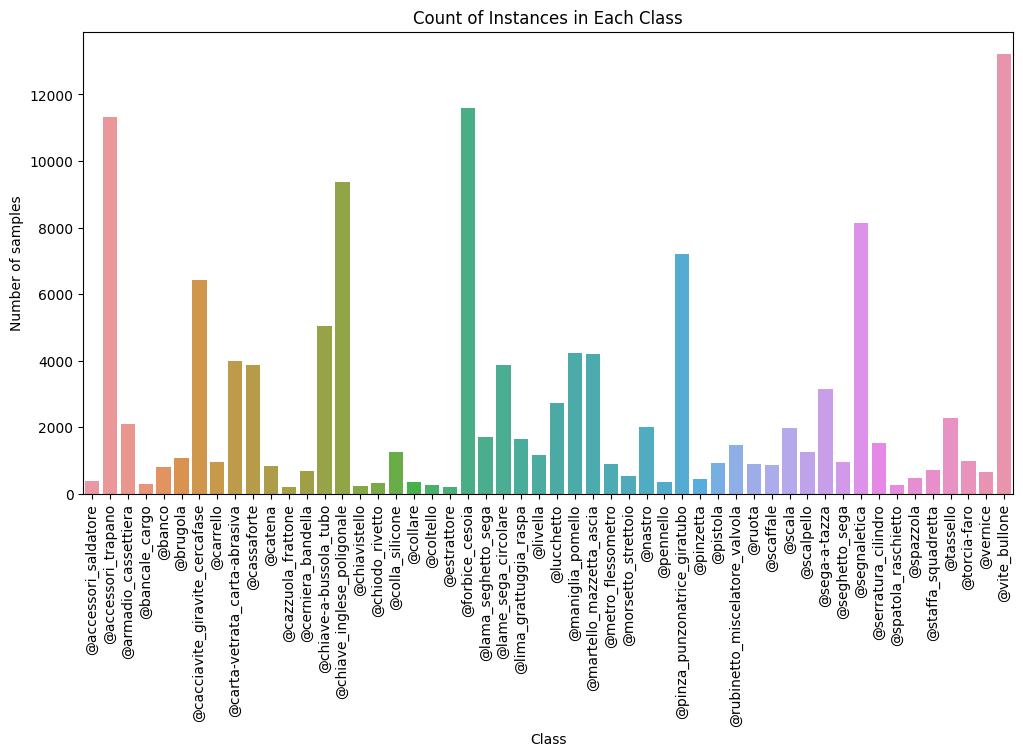

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

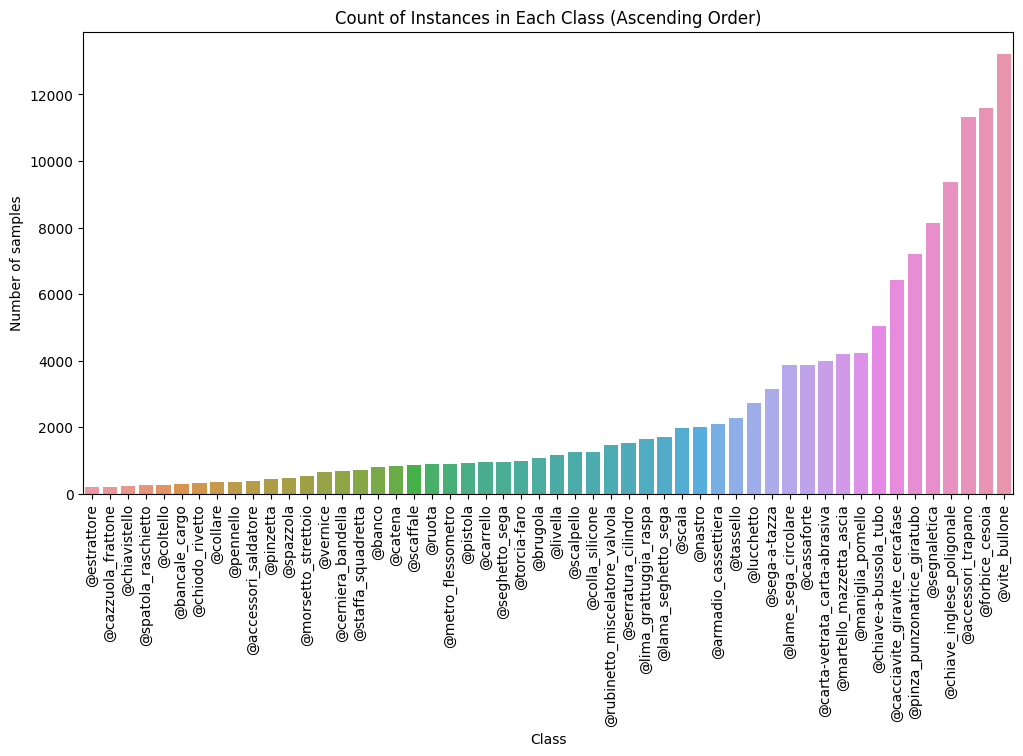

In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()


# Loading ResNet-101

In [ ]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 52


In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # 52 is the number of classes in your dataset
resnet.to(device)
print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Fine Tuning

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 30

In [ ]:
training_loss = []
resnet.train()

for epoch in range(num_epochs):
    # Set the model to training mode
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

Epoch 1/30 Loss: 0.9509
Epoch 2/30 Loss: 0.4287
Epoch 3/30 Loss: 0.3154
Epoch 4/30 Loss: 0.2542
Epoch 5/30 Loss: 0.2115
Epoch 6/30 Loss: 0.1763
Epoch 7/30 Loss: 0.1550
Epoch 8/30 Loss: 0.1372
Epoch 9/30 Loss: 0.1225
Epoch 10/30 Loss: 0.1058
Epoch 11/30 Loss: 0.0935
Epoch 12/30 Loss: 0.0853
Epoch 13/30 Loss: 0.0793
Epoch 14/30 Loss: 0.0691
Epoch 15/30 Loss: 0.0611
Epoch 16/30 Loss: 0.0554
Epoch 17/30 Loss: 0.0515
Epoch 18/30 Loss: 0.0445
Epoch 19/30 Loss: 0.0425
Epoch 20/30 Loss: 0.0387
Epoch 21/30 Loss: 0.0352
Epoch 22/30 Loss: 0.0325
Epoch 23/30 Loss: 0.0293
Epoch 24/30 Loss: 0.0271
Epoch 25/30 Loss: 0.0271
Epoch 26/30 Loss: 0.0243
Epoch 27/30 Loss: 0.0228
Epoch 28/30 Loss: 0.0221
Epoch 29/30 Loss: 0.0195


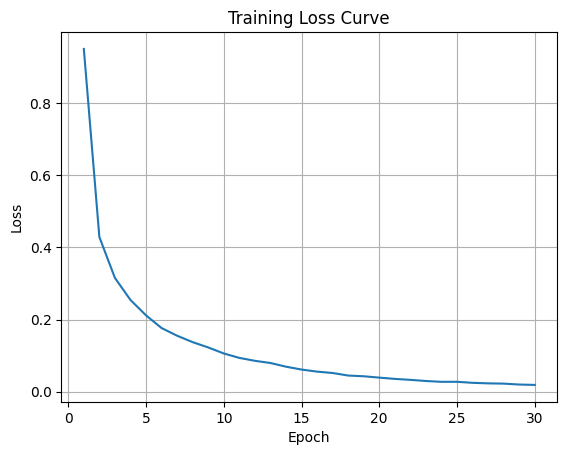

In [ ]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save and Download Model

In [ ]:
# save_dir = "/content/Model/ResNet_Joint_Representation/"
# os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# save_path = os.path.join(save_dir, 'model.pth')  # Specify the complete path to the model file
# torch.save(resnet.state_dict(), save_path)

In [ ]:
# !zip -r /content/ResNet_MultiModel.zip /content/Model/ResNet_MultiModel

In [ ]:
# from google.colab import files
# files.download("/content/ResNet_MultiModel.zip")

# Loading Validation Dataset and Preprocessing

In [ ]:
save_dir = '/content/Model/ResNet_Joint_Representation'
load_path = os.path.join(save_dir, 'model.pth')

# Create an instance of the ResNet model
resnet = torchvision.models.resnet101(pretrained=False)
resnet.fc = nn.Linear(2048, 52)

# Load the saved model parameters
resnet.load_state_dict(torch.load(load_path))

# Set the model to evaluation mode and respective device
resnet.eval()
resnet.to(device)

In [19]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [20]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [21]:
valPath = "/content/Data/text_encodings-images-val"
val_dataset = ValidationDataset(valPath)

In [22]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 21869
Number of classes: 52


In [23]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [24]:
class_lengths_dict = val_dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 52
Total sum: 21869
dict_values([59, 1879, 345, 48, 132, 176, 1069, 148, 663, 642, 136, 35, 112, 842, 1555, 36, 51, 206, 59, 43, 33, 1926, 281, 634, 270, 196, 450, 697, 695, 146, 85, 331, 54, 1196, 73, 148, 238, 146, 142, 327, 203, 522, 157, 1352, 254, 37, 80, 116, 379, 159, 106, 2200])


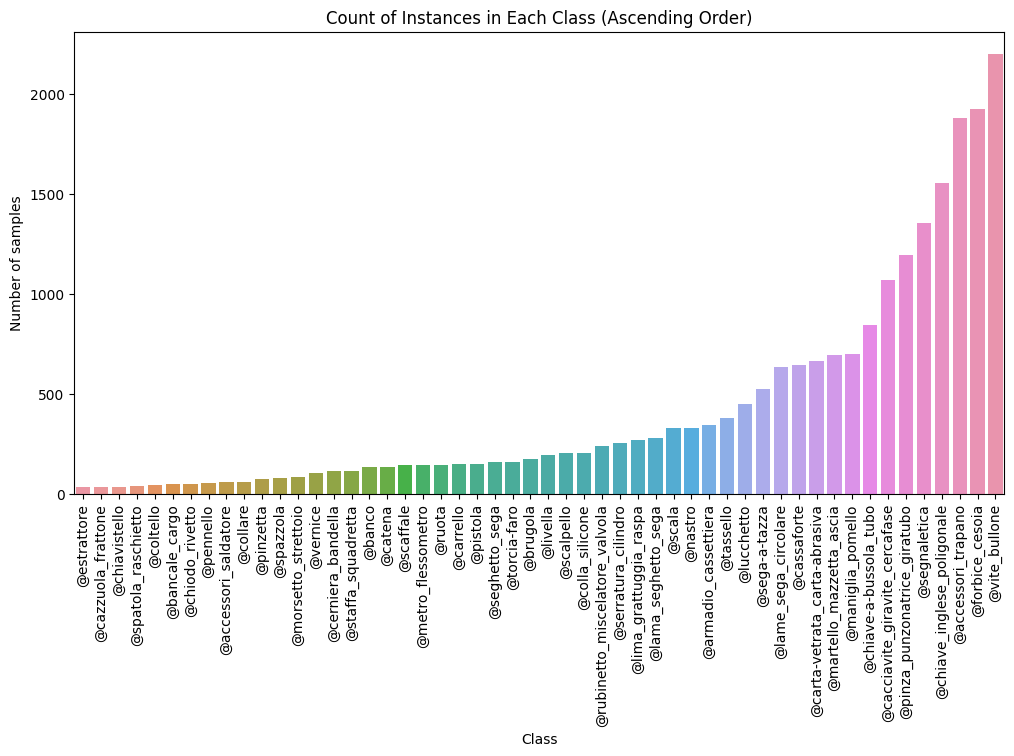

In [25]:
#  Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Sort the class labels and counts in ascending order
sorted_indices = sorted(range(len(class_counts)), key=lambda k: class_counts[k])
class_labels_sorted = [class_labels[i] for i in sorted_indices]
class_counts_sorted = [class_counts[i] for i in sorted_indices]

# Create a count plot with sorted data
plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels_sorted, y=class_counts_sorted)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class (Ascending Order)')
plt.show()

# Validation

In [26]:
resnet.eval()

predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in validation_data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = resnet(images)

        # Get the predicted labels
        _, predicted_label = torch.max(outputs, 1)

        # Store the predicted and true labels
        predicted_labels.extend(predicted_label.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

In [27]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.9260139924093466
Precision: 0.9263865693777094
Recall: 0.9260139924093466
F1-score: 0.9252168770859226


In [28]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.36      0.52        59
           1       0.94      0.96      0.95      1879
           2       0.98      0.91      0.94       345
           3       0.94      1.00      0.97        48
           4       0.95      0.96      0.96       132
           5       0.88      0.91      0.90       176
           6       0.97      0.99      0.98      1069
           7       0.91      0.86      0.89       148
           8       0.96      0.98      0.97       663
           9       0.96      0.99      0.97       642
          10       0.86      0.97      0.91       136
          11       0.84      0.89      0.86        35
          12       0.80      0.88      0.84       112
          13       0.94      0.92      0.93       842
          14       0.94      0.95      0.95      1555
          15       0.83      0.67      0.74        36
          16       0.86      0.84      0.85        51
          17       0.88    

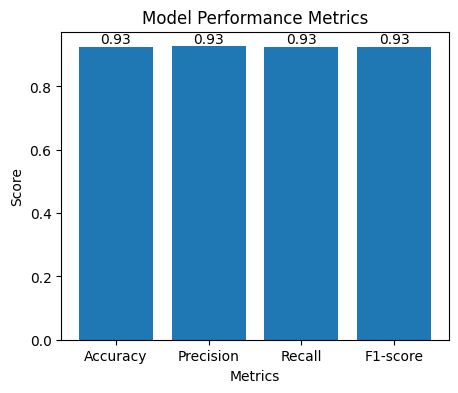

In [29]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

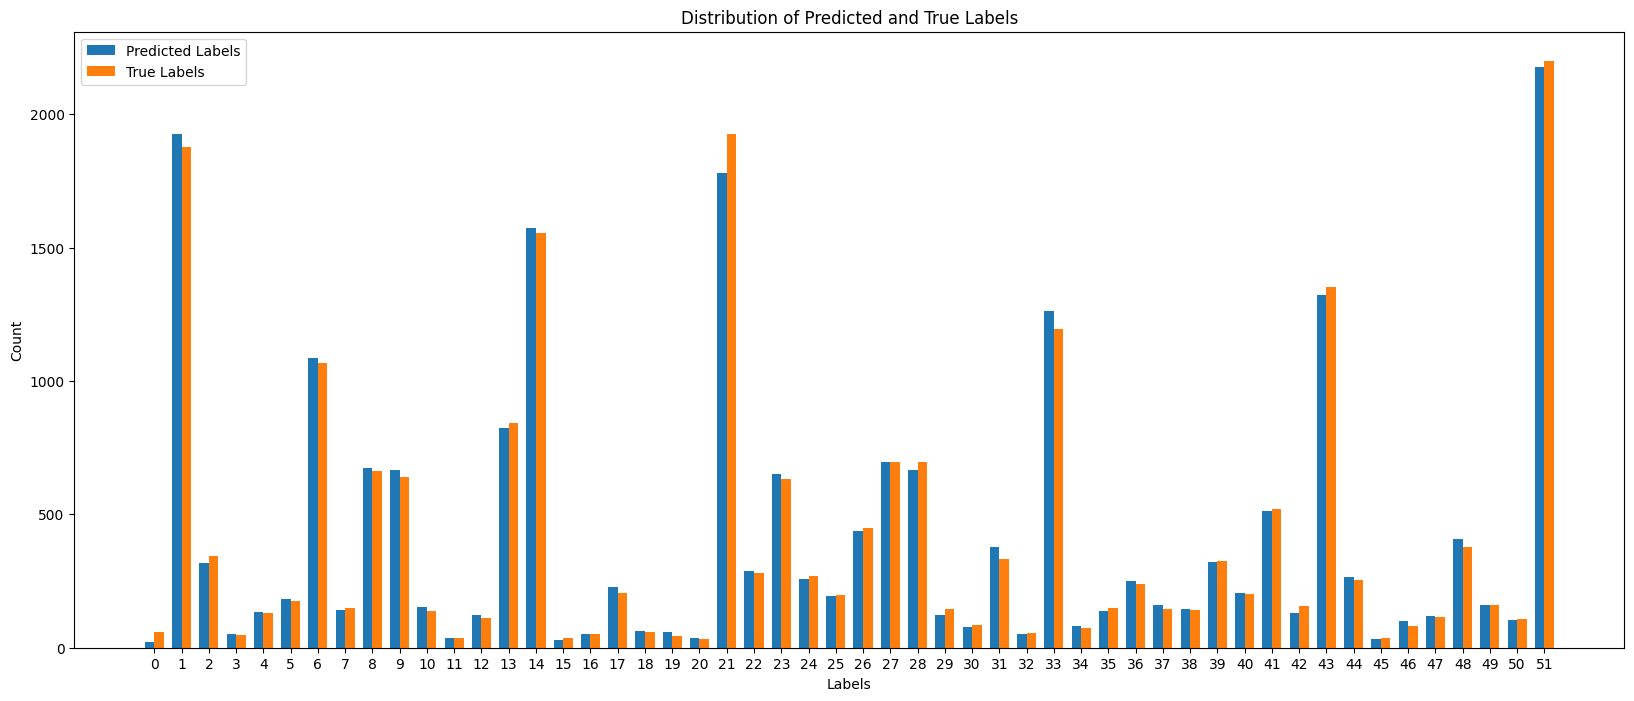

In [30]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_labels)
true_counts = np.bincount(true_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_labels, true_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Missing Modality Experiment

In [ ]:
# # Custom Class for Validation Experiment in case of different percentages of missing modalities
# class ValidationDataset(torch.utils.data.Dataset):
#     def __init__(self, data_dir):
#         self.data_dir = data_dir
#         self.dataset = datasets.ImageFolder(data_dir, transform=transform)
#         self.classes = sorted(os.listdir(data_dir))
#         self.class_lengths = self._compute_class_lengths()


#         # Load only 50% of data from each class
#         self.selected_indices = []
#         for class_idx in range(len(self.classes)):
#             indices = np.where(self.dataset.targets == class_idx)[0]
#             indices_3 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_3.png")]    # _3.png are the encoded_text images
#             indices_4 = [idx for idx in indices if self.dataset.samples[idx][0].endswith("_4.png")]    # _4.png are the actual images

#             # Include all files ending with "_4.png"
#             self.selected_indices.extend(indices_4)

#             # Randomly select 50% of files ending with "_3.png"
#             num_samples_3 = len(indices_3)
#             num_samples_to_load_3 = int(0.5 * num_samples_3)
#             selected_indices_3 = np.random.choice(indices_3, num_samples_to_load_3, replace=False)

#             # Append the selected indices to the selected_indices list
#             self.selected_indices.extend(selected_indices_3)

#     def __len__(self):
#         # Return the total number of selected samples in the dataset
#         return len(self.selected_indices)

#     def __getitem__(self, idx):
#         # Retrieve and preprocess a sample from the dataset using the selected indices
#         selected_idx = self.selected_indices[idx]
#         image, label = self.dataset[selected_idx]

#         return image, label

#     # Compute the lenghts of classes
#     def _compute_class_lengths(self):
#         class_lengths = {cls: 0 for cls in self.classes}

#         for cls in self.classes:
#             cls_dir = os.path.join(self.data_dir, cls)
#             if os.path.isdir(cls_dir):
#                 class_lengths[cls] = len(os.listdir(cls_dir))

#         return class_lengths